<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Detection with Convolutional Neural Network

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing modules

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os

## Exploratory Data Analysis

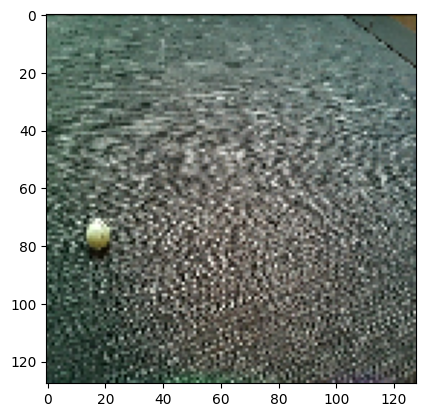

In [33]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball5.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

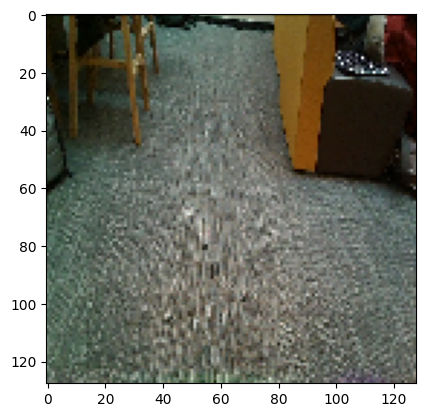

In [34]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty6.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

In [35]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

In [36]:
# Converting training sets to num arrays
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

# Adding no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

# Shuffle the combined dataset
# It's important to shuffle the data before splitting to ensure randomness
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

# Now split the combined dataset into a new training and test set
# You can specify the size of the test set with the 'test_size' parameter
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [37]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (632, 128, 128, 3)
X_test shape: (271, 128, 128, 3)
y_train shape: (632,)
y_test shape: (271,)


In [38]:
x_train_new[400:405]

array([[[[0.11372549, 0.21960784, 0.08235294],
         [0.11372549, 0.21960784, 0.09803922],
         [0.11372549, 0.21568628, 0.11764706],
         ...,
         [0.3372549 , 0.36078432, 0.17254902],
         [0.3372549 , 0.3529412 , 0.15294118],
         [0.36078432, 0.37254903, 0.16470589]],

        [[0.30588236, 0.49803922, 0.32156864],
         [0.29803923, 0.48235294, 0.31764707],
         [0.3019608 , 0.48235294, 0.3019608 ],
         ...,
         [0.5058824 , 0.5411765 , 0.28627452],
         [0.54901963, 0.58431375, 0.32941177],
         [0.5529412 , 0.5803922 , 0.31764707]],

        [[0.29803923, 0.5019608 , 0.32156864],
         [0.3019608 , 0.49019608, 0.33333334],
         [0.2901961 , 0.47843137, 0.3137255 ],
         ...,
         [0.53333336, 0.5686275 , 0.30588236],
         [0.5568628 , 0.5921569 , 0.34509805],
         [0.54901963, 0.57254905, 0.32941177]],

        ...,

        [[0.20392157, 0.21960784, 0.09019608],
         [0.28235295, 0.31764707, 0.14901961]

In [39]:
y_train_new[400:405]

array([1., 0., 0., 1., 1.])

## Model

In [40]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [41]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=10)

Epoch 1/10
20/20 [==============================] - 12s 531ms/step - loss: 0.6953 - accuracy: 0.5063 - val_loss: 0.6934 - val_accuracy: 0.4613
Epoch 2/10
20/20 [==============================] - 9s 469ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.4613
Epoch 3/10
20/20 [==============================] - 11s 548ms/step - loss: 0.6930 - accuracy: 0.4953 - val_loss: 0.6930 - val_accuracy: 0.4613
Epoch 4/10
20/20 [==============================] - 10s 515ms/step - loss: 0.6902 - accuracy: 0.5522 - val_loss: 0.6910 - val_accuracy: 0.4834
Epoch 5/10
20/20 [==============================] - 8s 409ms/step - loss: 0.6773 - accuracy: 0.6282 - val_loss: 0.6564 - val_accuracy: 0.6642
Epoch 6/10
20/20 [==============================] - 10s 503ms/step - loss: 0.6586 - accuracy: 0.6044 - val_loss: 0.6179 - val_accuracy: 0.7011
Epoch 7/10
20/20 [==============================] - 10s 495ms/step - loss: 0.6156 - accuracy: 0.6709 - val_loss: 0.6343 - val_accuracy: 0.6347
E

## History

In [42]:
history = pd.DataFrame(model.history.history)
model_loss = history.drop(columns=['accuracy', 'val_accuracy'])
model_accuracy = history.drop(columns=['loss', 'val_loss'])

<Axes: >

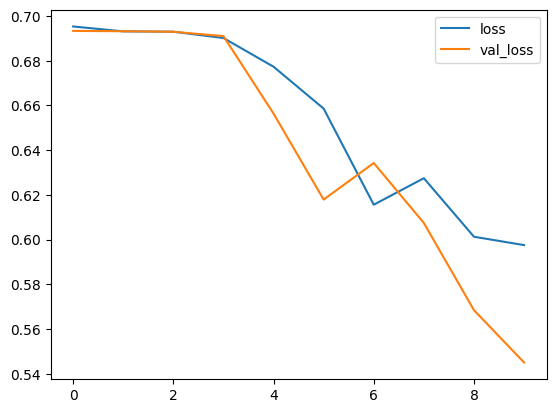

In [43]:
model_loss.plot()

<Axes: >

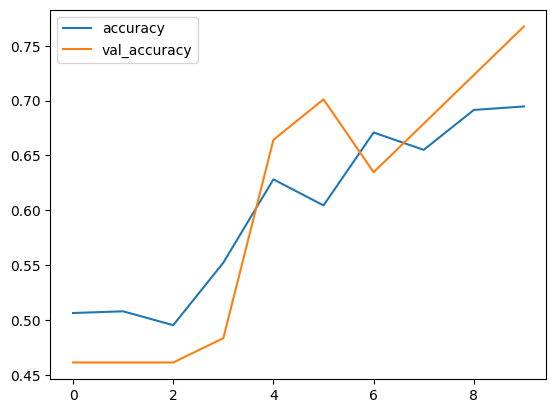

In [44]:
model_accuracy.plot()

## Model evaluation

In [45]:
predictions = np.rint(model.predict(x_test))

3/3 [==============================] - 1s 130ms/step


In [46]:
print( classification_report(y_test, predictions) )

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        40
         1.0       0.73      0.80      0.76        40

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



In [47]:
confusion_matrix(y_test, predictions)

array([[28, 12],
       [ 8, 32]])

Text(0.5, 1.0, 'prediction: [0.]')

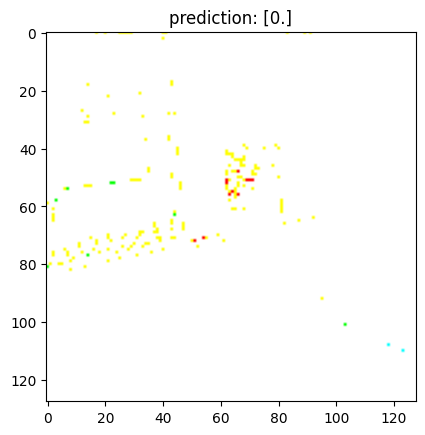

In [48]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [49]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load model

In [50]:
model = tf.keras.models.load_model('model.h5')